In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm
import itertools

# plt.style.use('fivethirtyeight')
# %matplotlib inline
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 13, 8

import plotly.express as px

# import collections

import functions as fun



import datetime
import seaborn as sns
sns.set()

In [2]:
%load_ext autoreload
%autoreload

In [3]:
%reload_ext autoreload

# Step 1: Read in Data

In [9]:
z_df = pd.read_csv('zillow_data.csv')
z_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [10]:
z_df.shape

(14723, 272)

The data contains the following values:

- RegionId - regions id (useful for mapping with fips?)
- RegionName - the zip code of the row
- City - city corresponding to the zip code
- State - state the zip code
- Metro - if applicable - the metro area corresponding to the city/zip code
- CountyName - county that the zip code belongs to
- SizeRank - this is based on population density (people per square mile) of the zip code --> 
    - lower scores = higher population density/more urbanized
    - higher scores = lower population density/less urbanized
- dates/home value - monthly home values from April, 1996 - April, 2018

It is important to have a good understanding of the data. 
We will therefore explore the various features.

### I started with a function for checking the total and percentages of missing values of each column.

In [11]:
missing = fun.missing_data(z_df)
missing

,Total,Percent
Metro,1043,7.084154
1997-03,1039,7.056986
1996-07,1039,7.056986
1997-06,1039,7.056986
1997-02,1039,7.056986
...,...,...
2014-05,56,0.380357
2014-04,56,0.380357
2014-02,56,0.380357
2014-01,56,0.380357


#### There are random missing values spread through a lot of the months 
- until we explore further this is not helpful yet
- until we scale to a specific location this is not helpful yet

### Chicago -->  I decided to only focus on Chicago zip codes because there are over 14,000 zip codes.
I believe that this is a great area for investment because:
- it is a large city with many zip codes
- it is highly urbanized and has potential for large growth / is constantly growing in population
- walkability scores 
- restaurants within walking distance
- possibility of looking into zip codes closest to public transportation
- low carbon emissions because of high population and urbanization

# Step 2: Data Preprocessing and Step 3: EDA and Visualization

In [12]:
# get only zip codes in Chicago
df_chicago = z_df.loc[z_df['City']=='Chicago']
df_chicago.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


In [13]:
# Let's make a back up to be safe from overriding
df_chicago_copy = df_chicago.copy()
# df_chicago_copy

In [14]:
chi_missing = fun.missing_data(df_chicago)
chi_missing

,Total,Percent
2006-12,1,2.439024
2007-02,1,2.439024
2000-06,1,2.439024
2006-11,1,2.439024
2006-10,1,2.439024
...,...,...
2012-01,1,2.439024
2012-02,1,2.439024
2012-03,1,2.439024
2012-04,1,2.439024


In [15]:
chi_missing.Total.nunique()

1

#### Looks like possibly only one row has null values.

In [16]:
missing_val = df_chicago.isnull()
null_row = missing_val.any(axis=1)
rows_with_missing = df_chicago[null_row]
rows_with_missing

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
105,84613,60611,Chicago,IL,Chicago,Cook,106,NaN,NaN,NaN,...,1475200,1473900,1469500,1472100,1477800,1486000,1497300,1508600,1508100,1493200


#### Discovered that the zip code 60611 is our row with missing data.
- It looks like there are months with missing data for this zip code - possibly didn't have early on data?


#### Change name of RegionName column to ZipCode to elimate confusion with RegionID column

In [17]:
df_chicago.rename(columns={'RegionName': 'ZipCode'}, inplace=True)
df_chicago.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


In [18]:
# make sure all zip codes are Cook County 
df_chicago['CountyName'].nunique()

1

In [19]:
df_chicago['ZipCode'].nunique()

41

In [20]:
df_chicago.shape

(41, 272)

### Now we have 41 zip codes to forecast with.

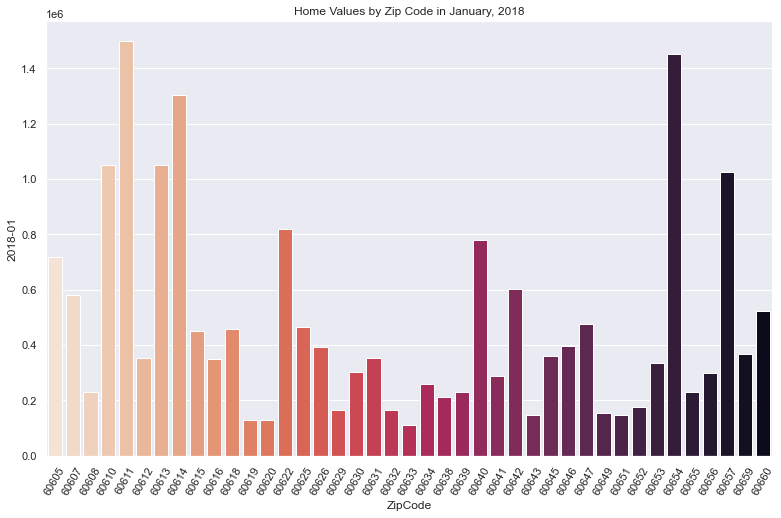

In [21]:
plt.figure(figsize=(13,8))
sns.barplot(x='ZipCode', y='2018-01', data=df_chicago, palette="rocket_r")
plt.title('Home Values by Zip Code in January, 2018')
plt.xticks(rotation=60)
plt.show()

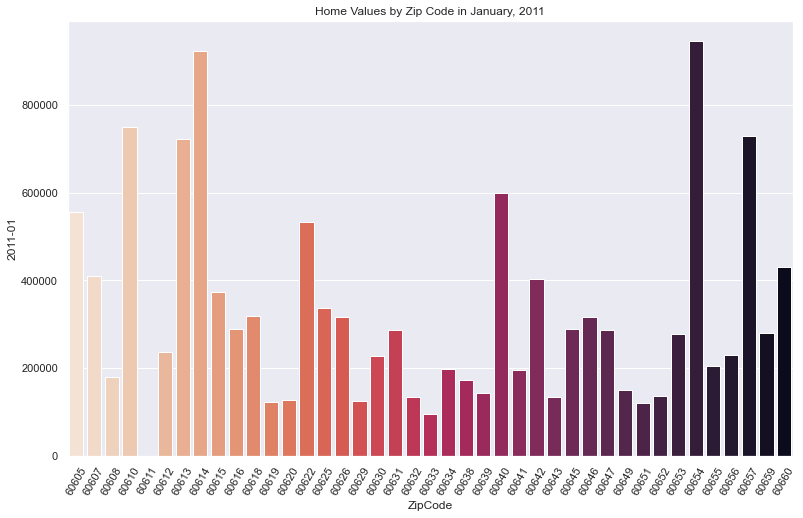

In [22]:
plt.figure(figsize=(13,8))
sns.barplot(x='ZipCode', y='2011-01', data=df_chicago, palette="rocket_r")
plt.title('Home Values by Zip Code in January, 2011')
plt.xticks(rotation=60)
plt.show()

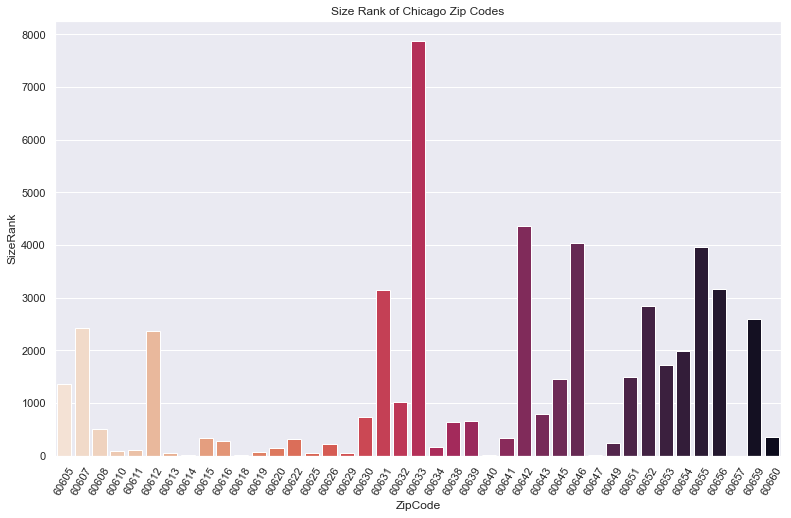

In [23]:
plt.figure(figsize=(13,8))
sns.barplot(x='ZipCode', y='SizeRank', data=df_chicago, palette="rocket_r")
plt.title('Size Rank of Chicago Zip Codes')
plt.xticks(rotation=60)
plt.show()

#### From here I decided to use size rank to filter through and lessen the zip code amount.
- I did not have a set amount of zip codes in mind
- Just play with different percentages

In [24]:
# I am dropping the column with no data until 2013 - I reference this below!!
df_chicago.dropna(inplace=True)
df_chicago['ZipCode'].nunique()

40

In [25]:
# filter zipcodes with a size rank in the bottom 50% (low score = highly urbanized zipcodes)
urban = df_chicago.SizeRank.quantile(q=0.50)
print(f'Size Rank 50% cutoff value: {urban}')
top_zips_df = df_chicago[df_chicago['SizeRank'] < urban]
print(f'Amount of zip codes: {top_zips_df.ZipCode.nunique()}')
top_zips_df.head()


Size Rank 50% cutoff value: 568.5
Amount of zip codes: 20


,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


In [26]:
top_zips_df.to_csv('top_zips_with_all_columns.csv', index=False)

In [27]:
## go back and make sure mapping dictionary is updated!!

In [28]:
# making a dictionary of zip codes with their corresponding region id's 
# because I may need them for plotting or identification of zip code location
# region
region_dict = {}
zip_list = top_zips_df.ZipCode.unique()
for i in zip_list:
    region = top_zips_df[top_zips_df['ZipCode']==i].RegionID.values[0]
    region_dict[i] = region

In [29]:
region_dict[60657]

84654

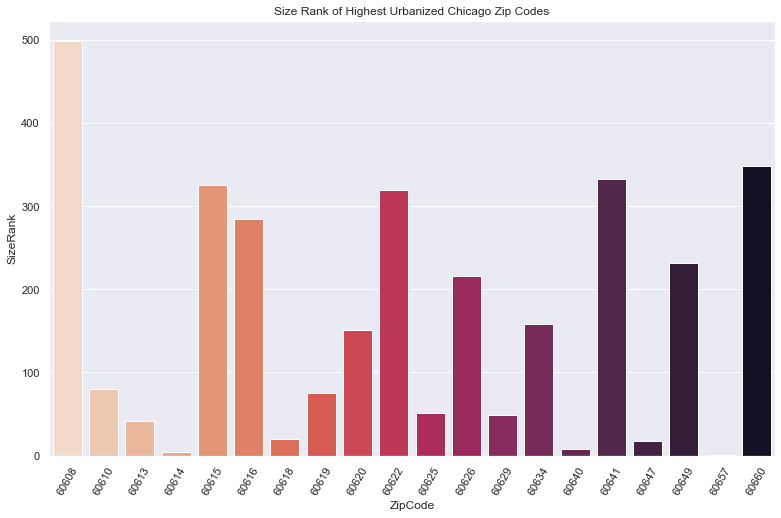

In [30]:
plt.figure(figsize=(13,8))
sns.barplot(x='ZipCode', y='SizeRank', data=top_zips_df, palette="rocket_r")
plt.title('Size Rank of Highest Urbanized Chicago Zip Codes')
plt.xticks(rotation=60)
plt.show()

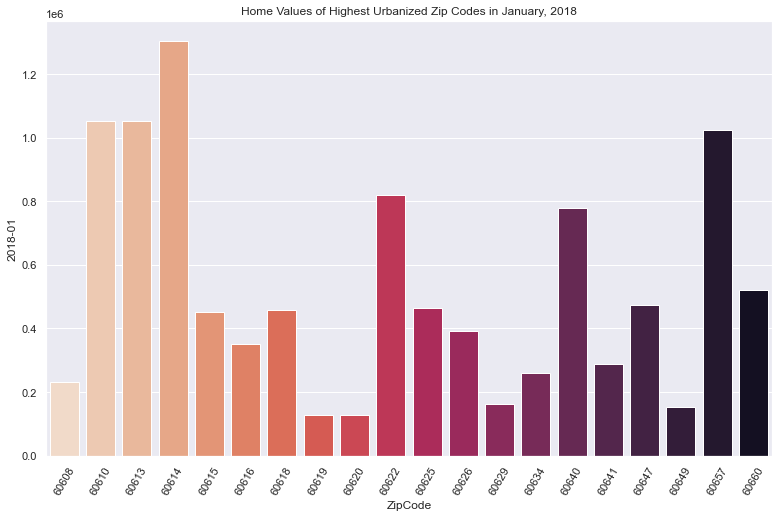

In [31]:
plt.figure(figsize=(13,8))
sns.barplot(x='ZipCode', y='2018-01', data=top_zips_df, palette="rocket_r")
plt.title('Home Values of Highest Urbanized Zip Codes in January, 2018')
plt.xticks(rotation=60)
plt.show()

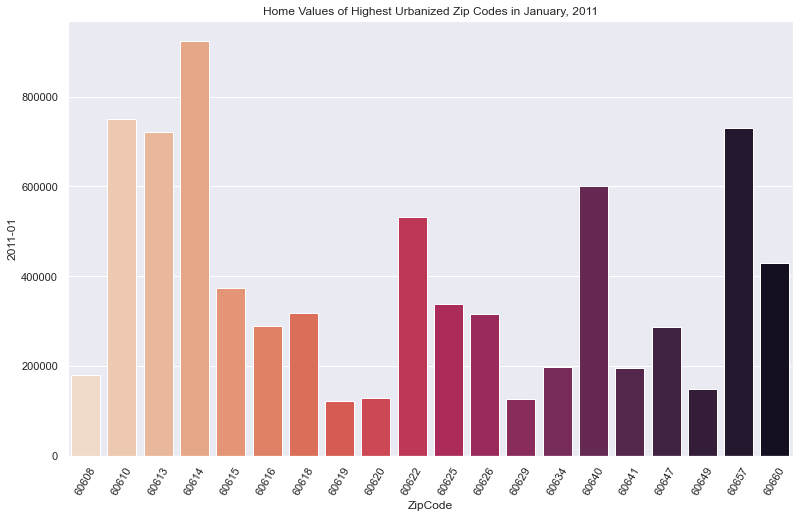

In [32]:
plt.figure(figsize=(13,8))
sns.barplot(x='ZipCode', y='2011-01', data=top_zips_df, palette="rocket_r")
plt.title('Home Values of Highest Urbanized Zip Codes in January, 2011')
plt.xticks(rotation=60)
plt.show()

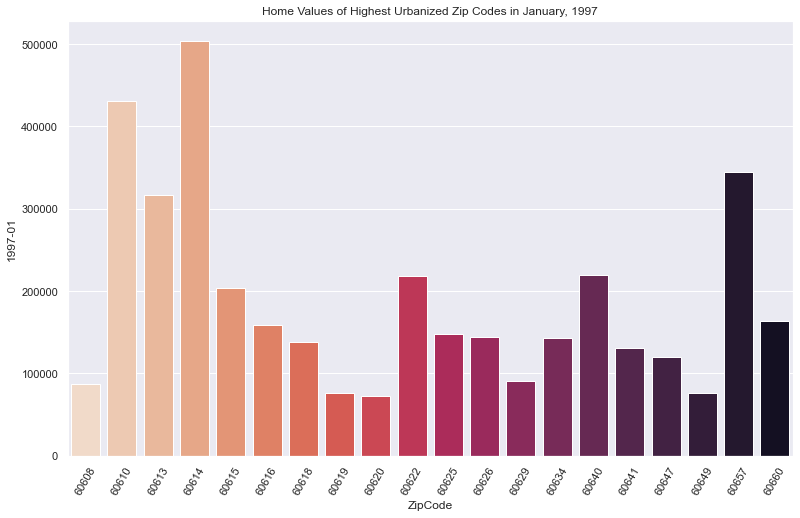

In [33]:
plt.figure(figsize=(13,8))
sns.barplot(x='ZipCode', y='1997-01', data=top_zips_df, palette="rocket_r")
# sns.catplot(x='ZipCode', y='1997-01',  data=top_zips_df, palette= 'rocket_r')
plt.title('Home Values of Highest Urbanized Zip Codes in January, 1997')
plt.xticks(rotation=60)
plt.show()

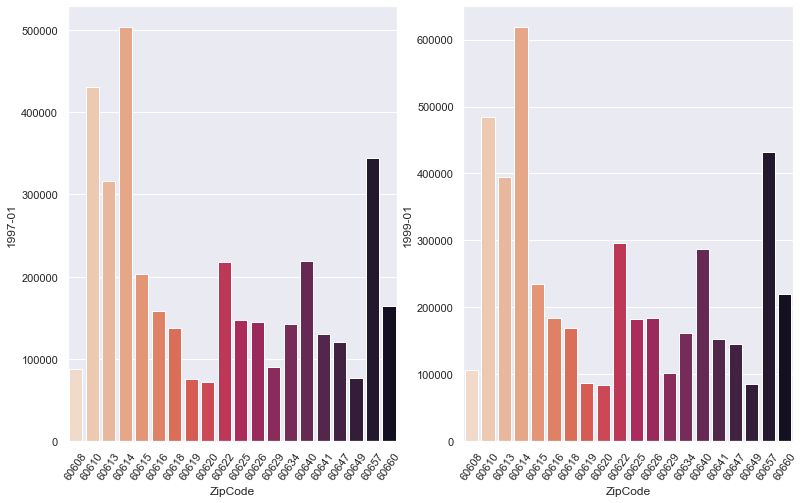

In [34]:
newfig = plt.figure(figsize = (13, 8))
ax = newfig.add_subplot(121)
ax2 = newfig.add_subplot(122)
ax.set_title('')
ax2.set_title('')
sns.barplot(x='ZipCode', y='1997-01', data=top_zips_df, palette="rocket_r",ax=ax,  )
sns.barplot(x='ZipCode', y='1999-01', data=top_zips_df, palette="rocket_r", ax=ax2)
# plt.setp(ax, xticks = [])
plt.setp(ax.get_xticklabels(), rotation=55)
plt.setp(ax2.get_xticklabels(), rotation=55)
# plt.xticks(rotation=50)
plt.close(2)
plt.close(3)

In [56]:
year_plot = pd.DataFrame()
year_plot['ZipCode'] = top_zips_df['ZipCode']
year_plot['1997-01'] = top_zips_df['1997-01']
year_plot['1999-01'] = top_zips_df['1999-01']

In [58]:
year_plot.set_index('ZipCode', inplace=True)
year_plot.head()

,1997-01,1999-01
ZipCode,,
60657,344400.0,432600.0
60614,503400.0,618600.0
60640,219700.0,287200.0
60647,120300.0,145300.0
60618,138000.0,169000.0


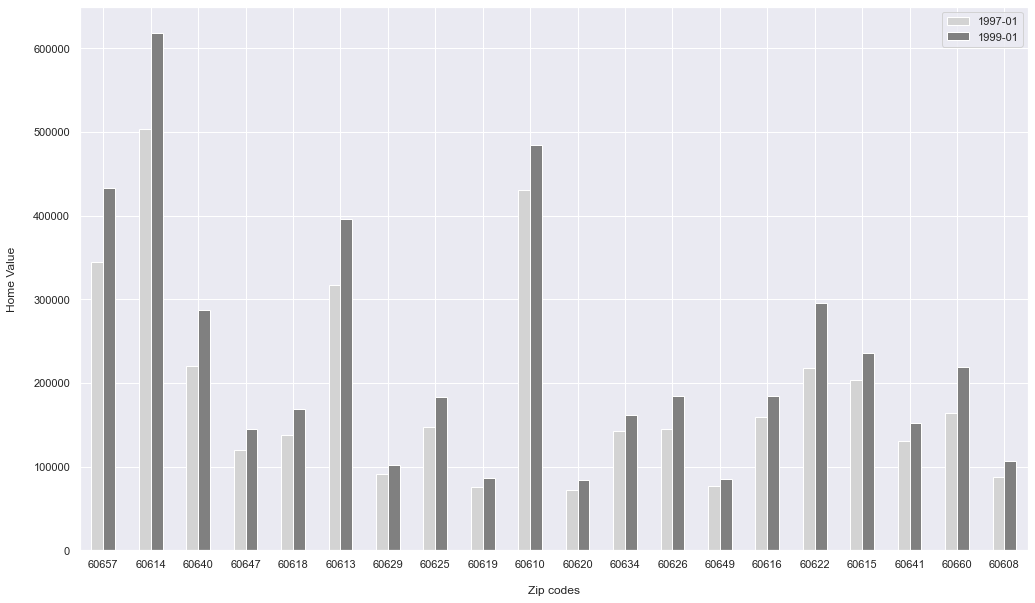

In [59]:
year_plot.plot(kind='bar', figsize=(17, 10), color=['lightgray', 'gray', 'black'], rot=0)                                       
plt.title("", y=1.013, fontsize=22)
plt.xlabel("Zip codes", labelpad=16)
plt.ylabel("Home Value", labelpad=16);

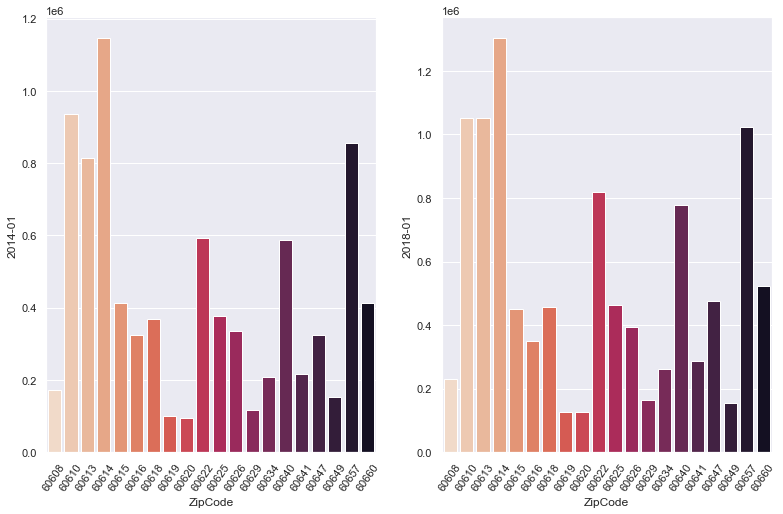

In [47]:
newfig = plt.figure(figsize = (13, 8))
ax = newfig.add_subplot(121)
ax2 = newfig.add_subplot(122)
ax.set_title('')
ax2.set_title('')
sns.barplot(x='ZipCode', y='2014-01', data=top_zips_df, palette="rocket_r",ax=ax,  )
sns.barplot(x='ZipCode', y='2018-01', data=top_zips_df, palette="rocket_r", ax=ax2)
# plt.setp(ax, xticks = [])
plt.setp(ax.get_xticklabels(), rotation=55)
plt.setp(ax2.get_xticklabels(), rotation=55)
# plt.xticks(rotation=50)
plt.close(2)
plt.close(3)

In [ ]:
top_zips_df.head()

### I wanted to drop some unnecessary columns to plot each zip code's value change over time.

In [ ]:
plotting_df = top_zips_df.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
plotting_df.head()

In [ ]:
## Reset index 
plot_df = plotting_df.reset_index(drop=True)
plot_df.head()

In [ ]:
## change zipcodes to string
plot_df["ZipCode"] = plot_df["ZipCode"].astype(str)

In [ ]:
## transpose dates to rows
plot_df = plot_df.transpose()
plot_df.head()

In [ ]:
## Renaming columns
header = plot_df.iloc[0] ## grab first row for the column names
plot_df = plot_df[1:] ## take all data after first row
plot_df.columns = header ## reassign all columns to zipcodes
plot_df.head()

In [ ]:
# fun.plot(plot_df)
plot_df.plot(figsize=(13, 8))
plt.title('Most Urbanized Zip Codes across 1996-2018 by Home Value')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.xlabel('Dates')
plt.ylabel('Home Value')
plt.show()

### From the plot above - It is clear that the 2008 economic crash had a large impact on values in Chicago 
- I decided to discard of all dates prior to 2011 where it starts to even out

In [ ]:
plot_df = plot_df.loc[plot_df.index >= '2011-01']
plot_df.head()

In [ ]:
# # fun.plot(plot_df)
plot_df.plot(figsize=(13, 8))
plt.title('Most Urbanized Zip Codes across 2011-2018 by Home Value')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.xlabel('Dates')
plt.ylabel('Home Value')
plt.show()

In [ ]:
plot_df.head()

### OK!  Looks good - these are the zip codes and years we will model with.

In [ ]:
# save our filtered dataframe for future use and to prevent overriding
# NO INDEX with function ran !!
fun.get_index_ready(plot_df)

plot_df.to_csv('plot_df.csv', index=False)

# Step 4: Reshape from Wide to Long Format

In [5]:
top_zips_df.head()

NameError: name 'top_zips_df' is not defined

In [ ]:
for col in top_zips_df.columns:
    if col < '2011-01':
        top_zips_df.drop([col], inplace=True, axis=1)

top_zips_df.head()

In [ ]:
def melt_data(df): # from flatiron starter notebook
    melted = pd.melt(df, id_vars=['RegionID','ZipCode', 'City', 'State', 'Metro', 'CountyName','SizeRank'], var_name='Time', value_name='Value')
    melted['Time'] = pd.to_datetime(melted['Time'], format='%Y-%m')
    melted = melted.dropna(subset=['Value'])
    return melted

In [ ]:
df = melt_data(top_zips_df)
df.head()

In [ ]:
df.drop(['RegionID', 'City', 'State', 'Metro', 
                     'CountyName', 'SizeRank'], inplace=True, axis=1)
# df.head()


In [ ]:
df.head()

In [ ]:
# no index
# df.to_csv('chicago_melted.csv', index=False)

In [ ]:
# df.set_index('Time', inplace = True)
# df.head()

In [ ]:
y = pd.DataFrame(df.groupby('Time')['Value'].mean())
y.head()

In [ ]:
# all of chicago with mean values - no zip
y.plot(figsize=(13, 8))
plt.xlabel("Year", fontsize=16)
plt.ylabel("Home Value", fontsize=16)
plt.title("Mean Home Value for Top Urbanized Chicago Zipcodes", fontsize=20)
plt.show()

# ROI Evaluations:

In [ ]:
plotting_df.head()

In [ ]:
roi_df = plotting_df.copy()
roi_df.head()

### I want to first take the average of every year so as not to lose any valuable information.

In [ ]:
year_list = ['1996', '1997','1998', '1999','2000', '2001','2002',
             '2003','2004','2005','2006','2007','2008','2009',
             '2010','2011', '2012', '2013', '2014', '2015', 
             '2016', '2017', '2018']

In [ ]:
%reload_ext autoreload

In [ ]:
for year in year_list:
    fun.get_mean_year(roi_df, year)

In [ ]:
roi_df.head()

### Toss all individual months since I now have the average home value for each year

In [ ]:
for col in roi_df:
    if '-' in col:
        roi_df.drop([col], inplace=True, axis=1)
roi_df.head()

In [ ]:
# flipping it for our plot function
plot_roi = roi_df.transpose()

new_header = plot_roi.iloc[0] 
plot_roi = plot_roi[1:] 
plot_roi.columns = new_header 

### Below is full range of dates - I just wanted to confirm that the 2008 economic crash looked the same with the averages for the years and it does.

In [ ]:
# average value for each year 
fun.plot(plot_roi)

#### again eliminating all years before 2011 to account for 2008 crash

In [ ]:
roi_clean = roi_df.copy()

for col in roi_df.columns:
    if col < '2011':
        roi_df.drop([col], inplace=True, axis=1)

roi_df.head()

In [ ]:
roi_df['2012-01'] = fun.get_return_rate('2011', '2012', roi_df)
roi_df['2013-01'] = fun.get_return_rate('2012', '2013', roi_df)
roi_df['2014-01'] = fun.get_return_rate('2013', '2014', roi_df) 
roi_df['2015-01'] = fun.get_return_rate('2014', '2015', roi_df)
roi_df['2016-01'] = fun.get_return_rate('2015', '2016', roi_df) 
roi_df['2017-01'] = fun.get_return_rate('2016', '2017', roi_df) 
roi_df['2018-01'] = fun.get_return_rate('2017', '2018', roi_df) 
roi_df.drop(['2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018'], inplace=True, axis=1)
roi_df.head()

In [ ]:
mean_roi = roi_df.copy()

In [ ]:
roi_df.columns

In [ ]:
roi_df.ZipCode.nunique()

In [ ]:
date_roi = roi_df.groupby('ZipCode').mean()
date_roi.head()

In [ ]:
zip_roi = date_roi.transpose()
zip_roi

In [ ]:
zip_roi.plot(figsize=(13, 8))
plt.xlabel('Years', fontsize=16)
plt.ylabel('Percent ROI',  fontsize=16)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", ncol=2)
plt.title('Yearly ROI for Selected Highly Urbanized Chicago Zip Codes',  fontsize=20)
plt.show()

### Let's filter out only the zip codes with an ROI percentage over 3% in 2018.

In [ ]:
date_roi['2018-01'].unique()

In [ ]:
# filter zipcodes ROI over 3% in 2018

top_percent = date_roi['2018-01'].quantile(q=0.75)
print(f'2018 ROI 75% cutoff value: {top_percent}')
top_roi = date_roi[date_roi['2018-01'] > top_percent]
print(f'Amount of zip codes: {top_roi.index.nunique()}')
top_roi.head()


In [ ]:
top_roi.index

In [ ]:
top_roi_plot = top_roi.transpose()
top_roi_plot

In [ ]:
top_roi_plot.plot(figsize=(13, 8))
plt.xlabel('Years', fontsize=16)
plt.ylabel('Percent ROI',  fontsize=16)
plt.legend(bbox_to_anchor=(1, 1), loc="best", ncol=2)
plt.title('Yearly ROI for Zip Codes with Highest ROI% in 2018',  fontsize=20)
plt.show()

In [ ]:
date_roi.head()

In [ ]:
# TOP Chicago Zip Codes by % ROI in 2018

plt.figure(figsize = (13,8))
plt.bar(top_roi.index, top_roi['2018-01'], color='purple')
plt.title('Chicago Zip Codes Over 3 % ROI in 2018')
plt.xlabel('Zip Code')
plt.xticks(rotation=30)
plt.ylabel('% ROI')
plt.show()

In [ ]:
import cufflinks as cf
cf.go_offline()
top_roi_plot.iplot(title="ROI of Chicago Homes 2011-2018",
                    xTitle="Year",
                    yTitle="Percent ROI",
                   shape=(13,8),
                    subplot_titles=True,
                    fill=True,)

In [ ]:
# roi_clean.head()
for col in roi_clean.columns:
    if col < '2011':
        roi_clean.drop([col], inplace=True, axis=1)

roi_clean.head()

In [ ]:
# roi_clean = roi_clean.set_index('ZipCode')

roi_clean = roi_clean.transpose()
roi_clean.head()

In [ ]:
# roi_clean = roi_clean.loc([roi_clean['ZipCode']==60613] |
#                           [roi_clean['ZipCode']==60622] |
#                           [roi_clean['ZipCode']==60629] |
#                           [roi_clean['ZipCode']==60634] |
#                           [roi_clean['ZipCode']==60641])


top_roi_list = [60613, 60622, 60629, 60634, 60641]

for col in roi_clean:
    if col not in top_roi_list:
        roi_clean.drop([col], inplace=True, axis=1)
        
    
roi_clean.head()

In [ ]:
roi_clean.iplot(title="Value of Chicago Homes 2011-2018",
                    xTitle="Year",
                    yTitle="Home Values",
                   shape=(13,8),
#                     subplot_titles=True,
                    fill=True,)

#### This below is to check our model against actual top 5 - if needed.

In [ ]:
top_2018 = top_zips_df.groupby('ZipCode')['2018-01'].mean().sort_values(ascending=False)
top_2018.head()

# DON'T TOUCH THIS GRAPH - 

In [ ]:
# # fun.plot(plot_df)
# plot_df.plot(figsize=(13, 8))
# plt.title('Home Values for Highest Urbanized Zip Codes 2011-2018')
# plt.xlabel('Years')
# plt.ylabel('Home Value')
# plt.show()

### Note on graph above!
- We notice a zip code here that does not have values before 2013 - 
- I decided here to discard of this zip code as well
- It was zip code 60611
- I then went back and re-filtered my urbanized zip codes to get back to 20


# Future Work:
- Mapping ROI or average home values for all states and picking a few for future work


In [ ]:
z_df = pd.read_csv('zillow_data.csv')
z_df.head()

In [ ]:
z_df.drop(['RegionID', 'SizeRank'], inplace=True, axis=1)
z_df.rename({'RegionName': 'ZipCode'}, inplace=True, axis=1)
z_df.head()

In [ ]:
year_list = ['1996', '1997','1998', '1999','2000', '2001','2002',
             '2003','2004','2005','2006','2007','2008','2009',
             '2010','2011', '2012', '2013', '2014', '2015', 
             '2016', '2017', '2018']

In [ ]:
for year in year_list:
    fun.get_mean_year(z_df, year)
z_df.head()

In [ ]:
for col in z_df:
    if '-' in col:
        z_df.drop([col], inplace=True, axis=1)
z_df.head()

In [ ]:
z_df['2012-01'] = fun.get_return_rate('2011', '2012', z_df)
z_df['2013-01'] = fun.get_return_rate('2012', '2013', z_df)
z_df['2014-01'] = fun.get_return_rate('2013', '2014', z_df) 
z_df['2015-01'] = fun.get_return_rate('2014', '2015', z_df)
z_df['2016-01'] = fun.get_return_rate('2015', '2016', z_df) 
z_df['2017-01'] = fun.get_return_rate('2016', '2017', z_df) 
z_df['2018-01'] = fun.get_return_rate('2017', '2018', z_df) 
z_df.drop(['2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018'], inplace=True, axis=1)
z_df.head()

In [ ]:
z_df.drop(['1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010'], inplace=True, axis=1)
z_df.head()

In [ ]:
# map_df = pd.DataFrame()
# map_df['State'] = z_df['State']
# map_df['2018-04'] = z_df['2018-04']
# map_df['2017-04'] = z_df['2017-04']
# map_df.head()

In [ ]:
map_df['2018-04-01'] = fun.get_return_rate('2017-04', '2018-04', map_df)
map_df.head()

In [ ]:
states = map_df.groupby('State').mean()
states.head()

In [ ]:
states.reset_index(inplace=True)
states.head()

In [ ]:
states.sort_values('2018-04-01', ascending=False).head()

In [ ]:
fig = px.choropleth(states, locations='State', locationmode='USA-states',
                    color='2018-04-01', scope='usa', color_continuous_scale='Purples', 
            title='Percent Yearly Average ROI by State')
fig.show()